# Трансформер - генератор фанфиков

Установим и подключим все нужные библиотеки

In [ ]:
%pip install torch
%pip install math
%pip install numpy
%pip install tqdm
%pip install scikit-learn
%pip install torchtune
%pip install datasets
%pip install pickle
%pip install matplotlib
%pip install itertools
%pip install multiprocessing
%pip install tokenizers
%pip install corus
%pip install requests

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data
import math
import copy
import numpy as np
from tqdm.auto import tqdm, trange
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
import corus
import torchtune
from datasets import load_dataset
import pickle
import matplotlib.pyplot as plt
import random
from multiprocessing import Pool
import itertools
import requests
import scipy
from scipy import interpolate

## Подготовка данных для обучения

Обучать будем на русскоязычных фанфиках с сайта [https://ficbook.net/](https://ficbook.net/). Датасет взят с [huggingface/IlyaGusev/ficbook](https://huggingface.co/datasets/IlyaGusev/ficbook?not-for-all-audiences=true). Так как данных там очень много, была поднята отдельная машина на которой хранились фанфики (для более удобной работы и т.к. на мой комп они не влазили и отфильтровать и перемешать очень проблематично было), а так же были отфильтрованы по признаку "хотя бы 20 лайков за все время" и перемешаны.

In [2]:
metadata = []
k = 100000
cur = 0
req_url = "http://89.169.167.208:1234/metadata?start={}&count={}".format

while len(result := requests.get(req_url(cur, k)).json()) != 0:
    cur += len(result)
    metadata += result

print('Всего фанфиков: ', len(metadata))

Всего фанфиков:  597797


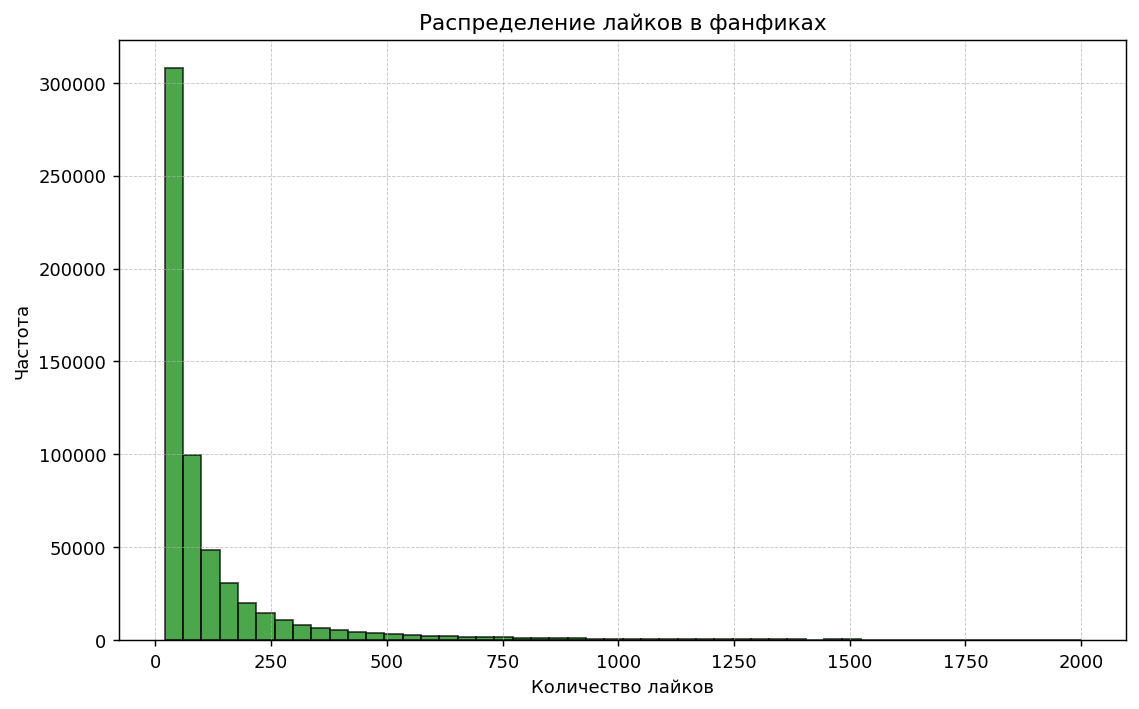

In [3]:
likes = [fanfic['likes'] for fanfic in metadata if fanfic['likes'] < 2000]

plt.figure(figsize=(10, 6), dpi=130)

plt.hist(likes, bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title("Распределение лайков в фанфиках")
plt.xlabel("Количество лайков")
plt.ylabel("Частота")

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

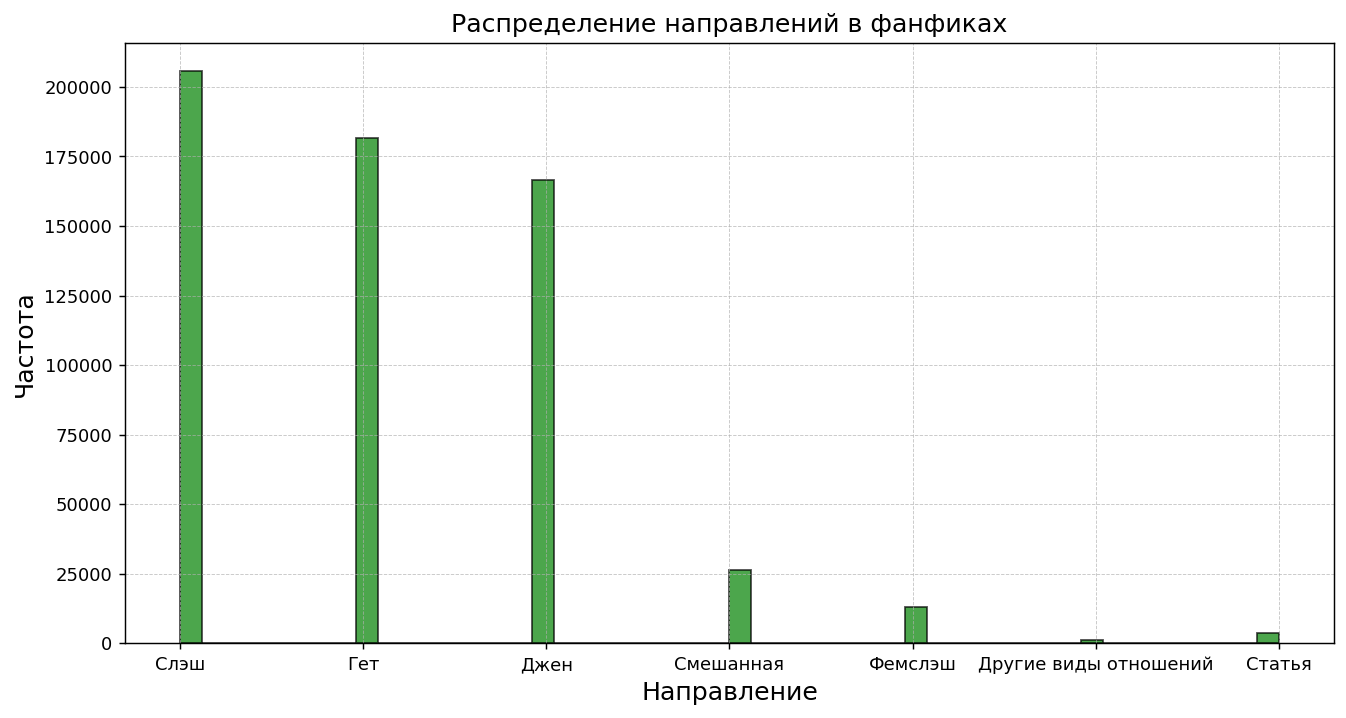

In [4]:
directs = [fanfic['direction'] for fanfic in metadata]

plt.figure(figsize=(12, 6), dpi=130)

plt.hist(directs, bins=50, color='green', edgecolor='black', alpha=0.7)
plt.title("Распределение направлений в фанфиках", fontsize=14)
plt.xlabel("Направление", fontsize=14)
plt.ylabel("Частота", fontsize=14)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [5]:
class BatchFanficRange:
    def __init__(self, batch_size, *args):
        self.batch_size = batch_size
        self.start = 0
        self.stop = 0
        self.step = 1
        self.k = min(5000, batch_size)
        self.req_url = "http://89.169.167.208:1234/fanfic?start={}&count={}".format
        if len(args) == 1:
            self.stop = args[0]
        elif len(args) == 2:
            self.start, self.stop = args
        elif len(args) == 3:
            self.start, self.stop, self.step = args
        else:
            raise ValueError("CustomRange expected at most 3 arguments, got {}".format(len(args)))

        if self.step == 0:
            raise ValueError("step argument must not be zero")

        if (self.start < self.stop and self.step > 0) or (self.start > self.stop and self.step < 0):
            self.length = max(0, (self.stop - self.start + self.step - (1 if self.step > 0 else -1)) // self.step)
        else:
            self.length = 0

    def __iter__(self):
        self.cur = self.start
        return self

    def __next__(self):
        if (self.step > 0 and self.cur >= self.stop) or (self.step < 0 and self.cur <= self.stop):
            raise StopIteration
        current = self.cur
        self.cur += self.step
        pos = current * self.batch_size
        data = []
        cnt = 0
        while len(result := requests.get(self.req_url(pos, self.k)).json()) != 0:
            pos += len(result)
            for i in range(len(result)):
                data += result[i]['parts']
                cnt += 1
                if cnt == self.batch_size:
                    random.shuffle(data)
                    return data
        return data

    def __len__(self):
        return self.length

In [6]:
class DataLoaderFanfic:
    def __init__(self, batch_size, repo_k, upd_k, all_k, start = 0):
        self.batch_size = batch_size
        self.current = 0
        self.total = 0
        self.upd_k = upd_k
        self.repo = []
        self.repo_k = repo_k
        self.all_k = all_k
        self.loader = iter(BatchFanficRange(batch_size, start, all_k))

    def recovery(self):
        if self.current > self.upd_k or self.total == self.all_k:
            return
        print('Start Recovery...')
        while self.current != self.repo_k and self.total < self.all_k:
            self.repo += next(self.loader)
            self.current += 1
            self.total += 1
        random.shuffle(self.repo)
        print('End recovery.')

    def __iter__(self):
        self.recovery()
        return self

    def __next__(self):
        self.recovery()
        if self.current == 0:
            raise StopIteration
        ans = self.repo[:len(self.repo) // self.current]
        self.repo = self.repo[len(self.repo) // self.current:]
        self.current -= 1
        return ans

    def __len__(self):
        return self.all_k

## Обучение токенайзера и обработка

### Токенайзер

In [7]:
vocab_size = 30000          # Размер словаря
max_seg_length = 1024       # Длины фрагментов на которых будем обучать

Так как датасет очень большой, обучение было только на 1/3 данных

In [ ]:
tokenizer = ByteLevelBPETokenizer()

tokenizer.train_from_iterator(tqdm(BatchFanficRange(5000, 40), total=40), vocab_size=vocab_size, min_frequency=5, special_tokens=[
    "<s>", "<pad>", "</s>", "<unk>", "<mask>"
])

tokenizer.save_model(".", "/workspace/bpe_tokenizer")

In [8]:
tokenizer = ByteLevelBPETokenizer(
    "/workspace/bpe_tokenizer-vocab.json",
    "/workspace/bpe_tokenizer-merges.txt"
)

Проверим, что он работает и посмотрим как он разбивает на токены

In [9]:
def mark_tokens(text: str):
    return '|'.join(tokenizer.decode([token]) for token in tokenizer.encode(text).ids)

mark_tokens('Привет! Я сказала, что люблю тебя так сильно!')

'Привет|!| Я| сказала|,| что| люблю| тебя| так| сильно|!'

### Обработка

In [10]:
def split_tokens_into_blocks(tokens):
    blocks = []
    start = 0

    while start < len(tokens):
        end = start + max_seg_length
        block_tokens = tokens[start:end]

        period_index = -1
        for i in range(len(block_tokens) - 1, -1, -1):
            b = tokenizer.decode([block_tokens[i]])[0]
            if b.endswith('\n'):
                period_index = i
                break
        if period_index == -1:
            for i in range(len(block_tokens) - 1, -1, -1):
                b = tokenizer.decode([block_tokens[i]])[0]
                if b.endswith('.'):
                    period_index = i
                    break
        if period_index == -1:
            for i in range(len(block_tokens) - 1, -1, -1):
                b = tokenizer.decode([block_tokens[i]])[0]
                if b.endswith('?'):
                    period_index = i
                    break
        if period_index == -1:
            for i in range(len(block_tokens) - 1, -1, -1):
                b = tokenizer.decode([block_tokens[i]])[0]
                if b.endswith('!'):
                    period_index = i
                    break

        if period_index != -1:
            end = start + period_index + 1
            block_tokens = tokens[start:end]

        blocks.append(block_tokens)
        start = end

    return blocks

def pad(text):
    if len(text) < max_seg_length:
        return np.array(text + [tokenizer.token_to_id('<pad>')] * (max_seg_length - len(text)))
    else:
        return np.array(text[:max_seg_length])

def get_tokens(text):
    return tokenizer.encode(text).ids

def filtering(text):
    if len(text) >= max_seg_length * 0.8:
        return True
    return False

def prepare_texts(texts):
    with Pool(9) as p:
        texts_tokens = list(tqdm(p.imap(get_tokens, texts)))
        texts_tokens = list(tqdm(p.imap(split_tokens_into_blocks, texts_tokens)))
        texts_tokens = [item for sublist in texts_tokens for item in sublist if filtering(item)]
        random.shuffle(texts_tokens)
        texts_tokens = list(tqdm(p.imap(pad, texts_tokens)))
    return texts_tokens

## Модель

Архитектура отличается от описанной в [Attention Is All You Need](https://arxiv.org/pdf/1706.03762):
* Так как мы решаем задачу генерации текста, а не перевода, то нам хватит только слоев Encoder'а. (подробнее в устройстве gpt-2 [Language Models are Unsupervised Multitask Learners](https://paperswithcode.com/method/gpt-2))

* Вместо стандартного синусоидного Positional Encoding'а использовался AliBi (подробнее [TRAIN SHORT, TEST LONG: ATTENTION WITH LINEAR BIASES ENABLES INPUT LENGTH EXTRAPOLATION](https://arxiv.org/pdf/2108.12409))

* Было изменено местоположение слоев нормализации (Pre-LN вместо Post-LN), т.к. в Post-LN модели есть проблемы с градиентами. (подробнее [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745))

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

In [12]:
class ALiBiConfig:
    d_model: int = 256
    num_heads: int = 8
    max_len: int = 256
    dropout: float = 0.1
    causal: bool = True

def get_relative_positions(seq_len: int) -> torch.tensor:
    x = torch.arange(seq_len)[None, :]
    y = torch.arange(seq_len)[:, None]
    return (x - y).to(device)


def get_alibi_slope(num_heads):
    x = (2 ** 8) ** (1 / num_heads)
    return (
        torch.tensor([1 / x ** (i + 1) for i in range(num_heads)])
        .unsqueeze(-1)
        .unsqueeze(-1)
        .to(device)
    )

class ALiBiMultiHeadAttention(nn.Module):
    def __init__(self, config: ALiBiConfig) -> None:
        super().__init__()
        self.causal = config.causal
        self.num_heads = config.num_heads
        self.scale = math.sqrt(config.d_model)
        self.dropout = nn.Dropout(config.dropout)
        self.register_buffer("m", get_alibi_slope(self.num_heads))
        self.kqv = nn.Linear(config.d_model, 3 * config.d_model, bias=False)
        if config.causal:
            self.register_buffer(
                "mask", torch.tril(torch.ones(1, 1, config.max_len, config.max_len))
            )

    def forward(self, x: torch.tensor) -> torch.tensor:
        batch_size, seq_len, _ = x.shape

        key, query, value = self.kqv(x).chunk(3, dim=-1)
        key = key.view(batch_size, seq_len, self.num_heads, -1).permute(0, 2, 3, 1)
        query = query.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)
        value = value.view(batch_size, seq_len, self.num_heads, -1).transpose(1, 2)

        bias = (self.m * get_relative_positions(seq_len)).unsqueeze(0)

        score = torch.matmul(query, key) / self.scale + bias

        if self.causal:
            score = score.masked_fill(
                self.mask[:, :, :seq_len, :seq_len] == 0, float("-inf")
            )

        attn = nn.functional.softmax(score, dim=-1)
        out = torch.matmul(attn, value)
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)
        out = self.dropout(out)

        return out

In [13]:
class EncoderLayer(nn.Module):
    def __init__(self, d_words, num_heads, d_ff, max_len):
        super(EncoderLayer, self).__init__()
        config = ALiBiConfig()
        config.d_model = d_words
        config.num_heads = num_heads
        config.max_len = max_len
        config.dropout = 0
        self.self_attn = ALiBiMultiHeadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(d_words, d_ff),
            nn.SiLU(),
            nn.Linear(d_ff, d_words),
        )
        self.norm1 = torchtune.modules.RMSNorm(d_words)
        self.norm2 = torchtune.modules.RMSNorm(d_words)

    def forward(self, x):
        attn_output = self.self_attn(self.norm1(x))
        x = x + attn_output
        ff_output = self.feedforward(self.norm2(x))
        x = x + ff_output
        return x

In [14]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_words, num_heads, num_layers, d_ff, max_seq_length):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(vocab_size, d_words)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_words, num_heads, d_ff, max_seq_length) for _ in range(num_layers)])

        self.fc = nn.Linear(d_words, vocab_size)


    def forward(self, x):
        enc_output = self.encoder_embedding(x)
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output)

        return self.fc(enc_output)

## Тренировка

In [15]:
d_words = 1024          # d_model
num_heads = 8           # количество голов attention'а
num_layers = 8          # количество слоёв encoder'а
d_ff = 4096             # размерность линейной части
batch_size = 28         # Максимальный размер батча влезающий в GPU

Параметры Адама взяты стандартные, скорость обучения подобрана экспериментальным путем

In [16]:
transformer = Transformer(vocab_size, d_words, num_heads, num_layers, d_ff, max_seg_length).to(device)
optimizer = optim.Adam(transformer.parameters(), lr=0.0002, betas=(0.9, 0.98), eps=1e-9)

In [17]:
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id('<pad>'))

vec_losses = []
gradient_norms = []

В процессе обучения происходило всякое, поэтому я периодически сохраняла модель (ниже в коде тренировки) и здесь загрузка модели из чекпоинта

In [18]:
transformer, optimizer = torch.load('/workspace/checkpoints/id1.model.tmp')

with open('/workspace/checkpoints/vec_losses1', 'rb') as f:
    vec_losses = pickle.load(f)

with open('/workspace/checkpoints/grad_norms1', 'rb') as f:
    gradient_norms = pickle.load(f)

print(len(vec_losses), vec_losses[-1])

1050 3.4078292474150658


Количество параметров у модели:

In [19]:
sum(param.nelement() for param in transformer.parameters())

153802032

Так как размер батча сейчас только 28 (см. выше), что довольно мало, то я делала шаг оптимизатора не на каждом батче, а раз в 20 батчей. (То есть увеличила итоговый размер батча в 20 раз). Ну а как показали эксперименты: больше батч - лучше. (подробнее [Training Tips for the Transformer Model](https://arxiv.org/pdf/1804.00247))

In [ ]:
transformer.train()
pos_save = 0
k = 100
batch_count = 20

for part_ind, batch_ in enumerate(tqdm(DataLoaderFanfic(10000, 7, 5, 50, 6), desc='Part')):
    train = prepare_texts(batch_)
    train = DataLoader(train, shuffle=True, batch_size=batch_size)
    losses = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train)):
        batch = batch.to(device)
        output = transformer(batch[:, :-1])
        loss = criterion(
            output.contiguous().view(-1, vocab_size),
            batch[:, 1:].contiguous().view(-1)
        )
        loss /= batch_count
        loss.backward()
        if i % batch_count == batch_count - 1:
            with torch.no_grad():
                gradient_norms.append([
                    (param.grad.norm().item(), param.nelement()) for param in transformer.parameters()
                ])
            optimizer.step()
            optimizer.zero_grad()
        l = loss.item()
        losses += l
        if i % k == k - 1:
            print('Loses', losses * batch_count / k, 'id save', pos_save, 'part', part_ind)
            vec_losses.append(losses * batch_count / k)
            losses = 0
            try:
                torch.save((transformer, optimizer), f"/workspace/checkpoints/id{pos_save}.model.tmp")
                with open(f'/workspace/checkpoints/vec_losses{pos_save}', 'wb') as f:
                    pickle.dump(vec_losses, f)
                with open(f'/workspace/checkpoints/grad_norms{pos_save}', 'wb') as f:
                    pickle.dump(gradient_norms, f)
                pos_save ^= 1
            except:
                print('You have a problems with save!!!')
    del train

### Графички

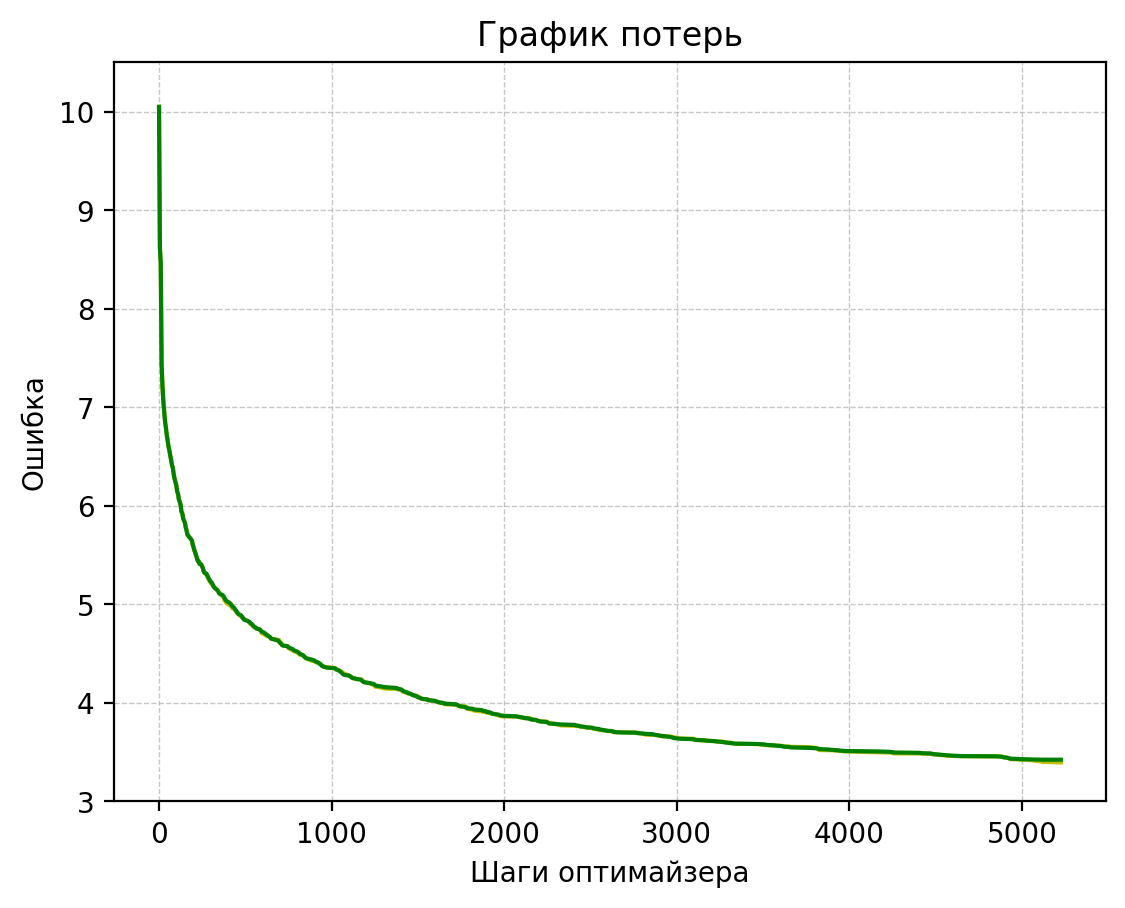

In [20]:
plt.figure(dpi=200)

with open('./workspace/checkpoints/vec_losses1', 'rb') as f:
    vec_losses = pickle.load(f)

y = np.array(vec_losses)
x = np.array(range(0, len(vec_losses) * 5, 5))

def filter_kek(d):
    res = []
    for i, v in enumerate(d):
        if len(res) == 0 or v < res[-1][0]:
            res.append((v, x[i]))
    return res

out = y
out = filter_kek(out)
x = [x[1] for x in out]
out = [x[0] for x in out]
plt.plot(x, out, 'y')
out = np.array(out)
p = 50
out = np.concatenate((out[:p], scipy.ndimage.gaussian_filter(out, sigma=10)[p:]))

plt.plot(x, out, 'g')
plt.ylim((3, 10.5))

plt.xlabel('Шаги оптимайзера')
plt.ylabel('Ошибка')

plt.title('График потерь')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)


plt.show()

Видим, что обучение на одной эпохе имеет примерно такой же график как и на нескольких. Что как раз говорится в исследовании [One Epoch Is All You Need](https://arxiv.org/pdf/1906.06669).

## Точная настройка

После обучения на большей части всех фанфиках, модель генерила текст, к сожаленению логичный только с точки зрения конструкции предложений. Связанность и адекватность текста отвратительна. Поэтому мы дообучим ее на не очень большом датасете, состоящем из коротких историй-фанфиков. Причины почему это должно улучшить:
* Сейчас модель довольно быстро скатывается в повторение одного и того же набора токенов: "люблю", "я не знаю", "я не могу", и так далее. Думаю, это потому что они часто встречаются, в каждом фанфике, может быть не один раз. В коротких историях этого меньше, т.к. там быстрее развитие действий.
* В больших (не коротких) фанфиках очень много текста уходит на внутренние мысли и рассуждения героя, все события более растянуты и из-за длины контекста 1024 могли исказиться. В коротких историях, история целиком помещается в контекст модели и сюжет взят не из середины, а с самого начала, а также все события происходят быстрее и у модели больше шансов понять структуру рассказов (что нам и нужно).

### Подготовка данных

In [21]:
data = []
k = 10000
cur = 0
req_url = "http://89.169.167.208:1235/fanfic?start={}&count={}".format

while len(result := requests.get(req_url(cur, k)).json()) != 0:
    cur += len(result)
    for fanfic in result:
        text = ""
        for part in fanfic['parts']:
            text += part + '\n'
        data.append(text[:-1])
    print(cur)

print('Всего коротких фанфиков: ', len(data))

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
253047
Всего коротких фанфиков:  253047


In [22]:
def Get(text):
    return tokenizer.encode(text).ids, len(text)

In [23]:
with Pool(9) as p:
    texts_tokens = list(tqdm(p.imap(Get, data)))

0it [00:00, ?it/s]

In [24]:
scale = [y / len(x) for (x, y) in texts_tokens]

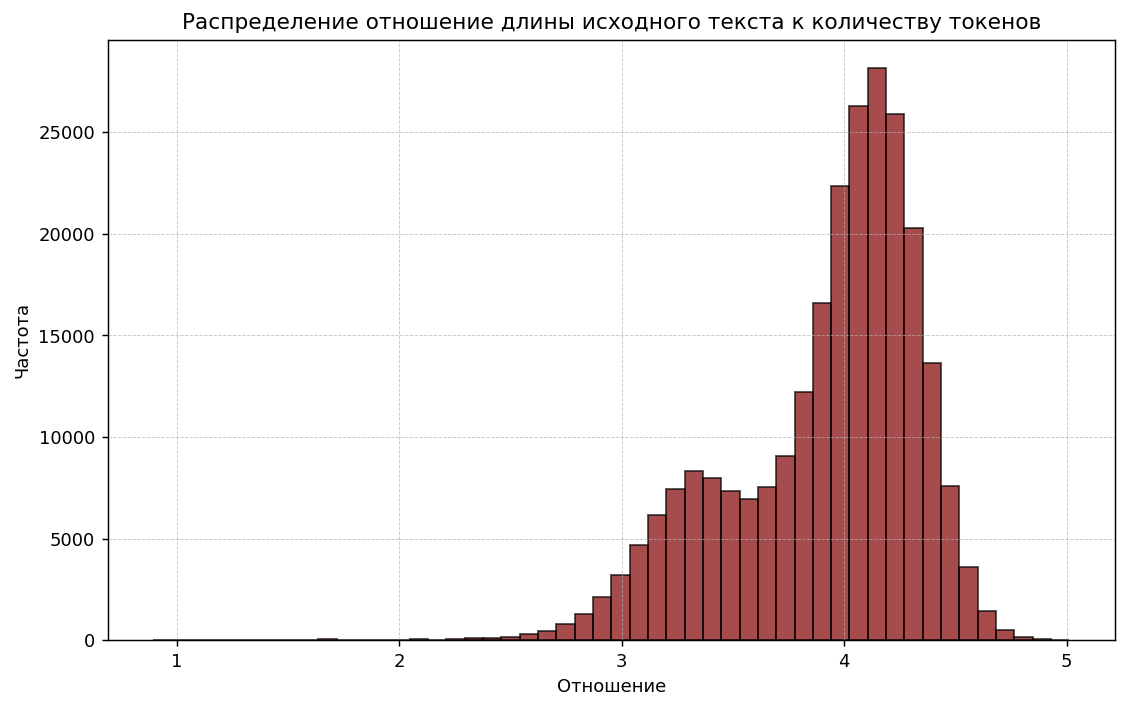

In [25]:
plt.figure(figsize=(10, 6), dpi=130)

plt.hist(scale, bins=50, color='maroon', edgecolor='black', alpha=0.7)
plt.title("Распределение отношение длины исходного текста к количеству токенов")
plt.xlabel("Отношение")
plt.ylabel("Частота")

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

Интересно, что кажется здесь два нормальных распределения сложились.

In [26]:
lens = [len(x) for (x, y) in texts_tokens]

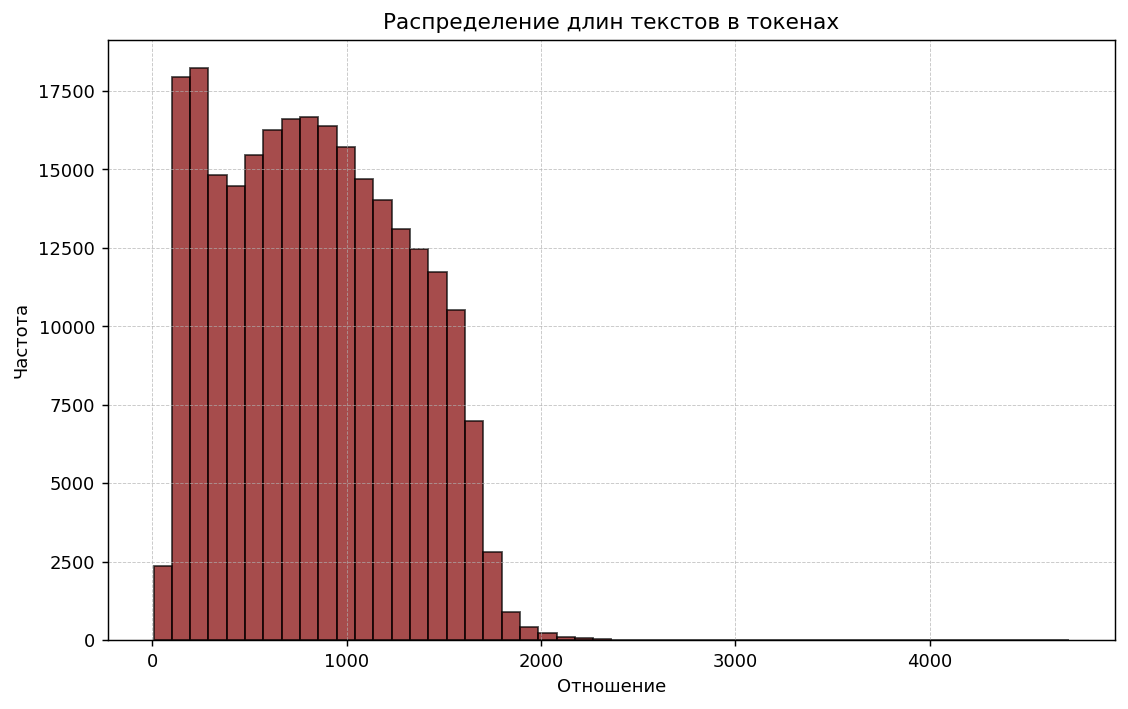

In [27]:
plt.figure(figsize=(10, 6), dpi=130)

plt.hist(lens, bins=50, color='maroon', edgecolor='black', alpha=0.7)
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Отношение")
plt.ylabel("Частота")

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [ ]:
texts_tokens = [x[:1024] for (x, y) in texts_tokens if len(x) >= 512 and len(x) <= 1500 and y / len(x) >= 3]

In [ ]:
random.shuffle(texts_tokens)
with Pool(9) as p:
    texts_tokens = list(tqdm(p.imap(pad, texts_tokens)))

with open('/workspace/small_fanfics', 'wb') as f:
    pickle.dump(texts_tokens, f)
del texts_tokens

### Обучение

In [ ]:
optimizer = optim.Adam(transformer.parameters(), lr=0.00005, betas=(0.9, 0.98), eps=1e-9)
vec_losses = []
with open('/workspace/small_fanfics', 'rb') as f:
    train = pickle.load(f)

In [ ]:
transformer.train()
pos_save = 0
k = 100
batch_count = 20
train = DataLoader(train, shuffle=True, batch_size=batch_size)

for epoch in trange(1):
    losses = 0
    optimizer.zero_grad()
    for i, batch in enumerate(tqdm(train)):
        batch = batch.to(device)
        output = transformer(batch[:, :-1])
        loss = criterion(
            output.contiguous().view(-1, vocab_size),
            batch[:, 1:].contiguous().view(-1)
        )
        loss /= batch_count
        loss.backward()
        if i % batch_count == batch_count - 1:
            optimizer.step()
            optimizer.zero_grad()
        l = loss.item()
        losses += l
        if i % k == k - 1:
            print('Loses', losses * batch_count / k, 'id save', pos_save)
            vec_losses.append(losses * batch_count / k)
            losses = 0
            try:
                torch.save((transformer, optimizer), f"/workspace/checkpoints/tune_kek_id{pos_save}.model.tmp")
                with open(f'/workspace/checkpoints/tune_kek_vec_losses{pos_save}', 'wb') as f:
                    pickle.dump(vec_losses, f)
                pos_save ^= 1
            except:
                print('You have a problems with save!!!')
    torch.save((transformer, optimizer), f"/workspace/checkpoints/tune_kek_ep{epoch}.model.tmp")
    with open(f'/workspace/checkpoints/tune_kek_vec_losses_ep{epoch}', 'wb') as f:
        pickle.dump(vec_losses, f)

### График обучения

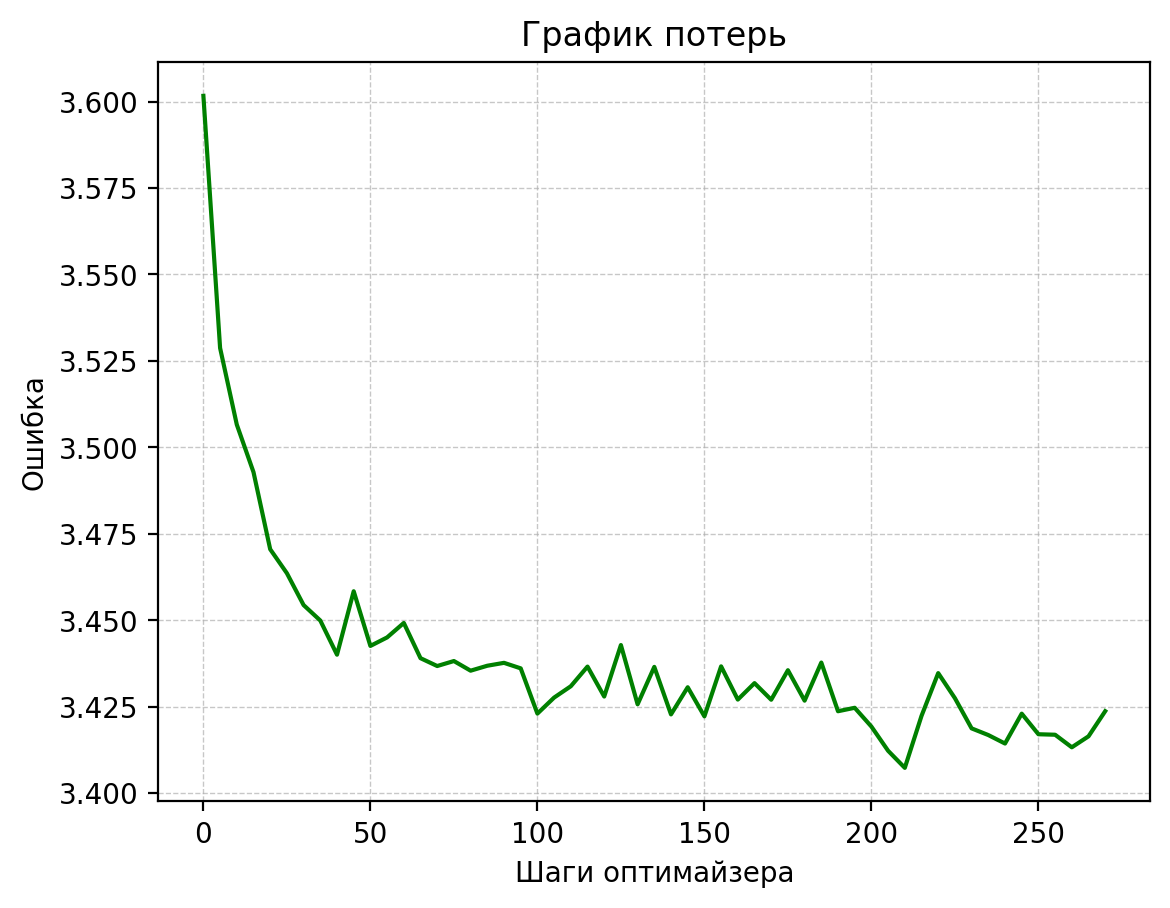

In [28]:
plt.figure(dpi=200)

with open('./workspace/checkpoints/tune_vec_losses_ep0', 'rb') as f:
    vec_losses = pickle.load(f)

y = np.array(vec_losses)
x = np.array(range(0, len(vec_losses) * 5, 5))

plt.plot(x, y, 'g')

plt.xlabel('Шаги оптимайзера')
plt.ylabel('Ошибка')

plt.title('График потерь')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)


plt.show()

## Генерация текста (Декодинг)

Упор на наказывание за повторяющиеся токены, а также на Nucleus Sampling или же Top-p. (подробнее [THE CURIOUS CASE OF NEURAL TEXT DeGENERATION](https://arxiv.org/pdf/1904.09751)

In [29]:
def to_tokens(text):
    return tokenizer.encode(text).ids


def to_text(tokens):
    return tokenizer.decode(tokens)


def mark_tokens(text: str):
    return '|'.join(tokenizer.decode([token]) for token in tokenizer.encode(text).ids)


def nucleus_filter(logits, p):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(nn.functional.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cumulative_probs > p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0

    indices_to_remove = sorted_indices[sorted_indices_to_remove]
    logits[indices_to_remove] = -float('Inf')
    return logits

In [30]:
def get_next_probs(model, tokens):
    if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
    ans = model(tokens.unsqueeze(0).to(device))
    return ans[0, -1, :]

def get_next_token(logits, p, t, penalties, g=None):
    logits = logits - penalties
    logits /= t
    logits = nucleus_filter(logits, p)
    probabilities = nn.functional.softmax(logits, dim=-1)
    next_token = torch.multinomial(probabilities, 1, generator=g)
    return next_token[0]


## Выпускай Кракена!

In [31]:
transformer, optim = torch.load('/workspace/checkpoints/tune_ep0.model.tmp', map_location=device)

In [32]:
transformer.eval()

def generator(s, cnt_tokens, g=None):
    tix = tokenizer.token_to_id('-')
    s_ = to_tokens(s)
    penalties = torch.zeros((tokenizer.get_vocab_size(),)).to(device)

    with torch.no_grad():
        for i in range(cnt_tokens):
            probs = get_next_probs(transformer, s_)
            sym = get_next_token(probs, 0.6, 0.6, penalties, g)
            s_.append(sym)
            penalties *= 0.95
            penalties[sym] += 3
            if sym != tix:
                penalties[sym] += 1

    return to_text(s_)

Пример 1.

In [33]:
g = torch.Generator(device=device).manual_seed(876545)
s = 'Я сидела в парке на'
print('Before:\n', s, '\nAfter:\n', generator(s, 100, g))

Before:
 Я сидела в парке на 
After:
 Я сидела в парке на скамейке и смотрела на небо. На улице было очень тихо, даже птицы не пели. Я сидела и наблюдала за облаками, которые только что были видны из-за горизонта.
Вдруг я услышала звук приближающихся шагов и обернулась. Это был Нацу, который стоял в наушниках и смотрел на меня своими большими карими глазами. Я не могла поверить своим глазам!
-Нацу? - тихо прошептала я, пытаясь скрыть дрожь в голосе.
-Что ты тут делаешь? - спросил он с улыбкой на лице. Я


Пример 2.

In [34]:
g = torch.Generator(device=device).manual_seed(522233)
s = 'Алиса и Боб шли вместе'
print('Before:\n', s, '\nAfter:\n', generator(s, 100, g))

Before:
 Алиса и Боб шли вместе 
After:
 Алиса и Боб шли вместе по парку.
- Ну, что ж... - сказал Боб и улыбнулся.
- Да! Я хочу мороженное с собой взять! - радостно воскликнула Алиса, и Бобу пришлось остановиться.
- Ну что ж... Это же здорово! - сказал Боб и улыбнулся.
- Ага, конечно! А ты хочешь мороженого? - спросила Алиса.
- Да... Хочу шоколадное мороженое с клубникой, а то я уже проголодался! - сказал Боб и улыбнулся.
- Ну


Пример 3.

In [35]:
g = torch.Generator(device=device).manual_seed(931143)
s = 'Эта история началась с'
print('Before:\n', s, '\nAfter:\n', generator(s, 100, g))

Before:
 Эта история началась с 
After:
 Эта история началась с того, что я потеряла сознание.
Я очнулась в больнице с переломом ноги и разбитым сердцем. Я лежала на кровати, а рядом лежал мой парень - это был тот самый блондин с голубыми глазами и серыми волосами. Он смотрел на меня так, будто я его убила.
- Ты не спишь? - спросил он меня хриплым голосом, от которого у меня побежали мурашки по коже.
- Нет... - прошептала я и попыталась встать с кровати, но не тут то было! Я почувствовала боль в
